In [156]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [157]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [202]:
meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])

# just get gid <-> tid this way
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df.rename({'isoform':'tid',
              'associated_gene': 'gid'},
             axis=1, inplace=True)

# use counts now instead of relative counts
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tsv'],od))[0]
df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df = df.merge(mt_df[['tid', 'gid']],
              how='left',
              on='tid')
assert len(df.loc[df.gid.isnull()]) == 0
df.sort_values(by='gid').head()
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
id_vars = ['tid', 'gid']
sample_columns = list(set(df.columns)-set(id_vars))

# remove transcripts that are wholly unexpressed
print(len(df.index))
df = df.loc[df[sample_columns].sum(axis=1)>0]
print(len(df.index))

# melt
print(df.shape)
df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                  var_name='sample', value_name='counts')
print(df.shape)

# add population info
df = df.merge(meta[['sample', 'population']], 
              how='left',
              on='sample')

155875
139153
(139153, 45)
(5983579, 4)


In [203]:
len(df.index)

5983579

In [204]:
139153*43

5983579

In [205]:
# gene expression / counts
f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
gene_df = pd.read_csv(f, sep='\t')
gene_df.head()
gene_df.sort_values(by='geneid.v').head()
gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
id_vars = ['gid']
sample_columns = list(set(gene_df.columns)-set(id_vars))
gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                  var_name='sample', value_name='g_counts')
df = df.merge(gene_df, 
              how='left',
              on=['gid', 'sample'])

## Groupby population and sum up all counts for each transcript

In [206]:
df.drop('sample', axis=1, inplace=True)
df = df.groupby(['tid', 'gid',
                 'population']).sum()
df = df.reset_index()

## What do non-0 expression values look like?

Use to figure out what pseudocount to add

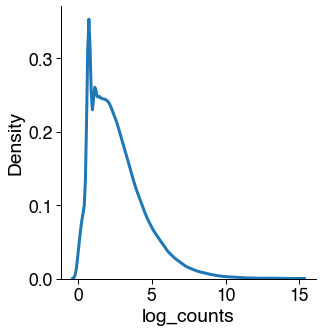

In [207]:
temp = df.loc[df.counts>0]
temp['log_counts']=np.log(temp.counts+1)

init_plot_settings(aspect='rectangle')
sns.displot(temp, kind='kde', x='log_counts', linewidth=3)

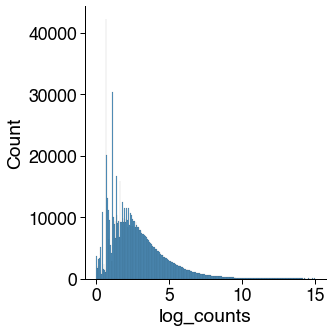

In [208]:
temp = df.loc[df.counts>0]
temp['log_counts']=np.log(temp.counts+1)

init_plot_settings(aspect='rectangle')
sns.displot(temp, x='log_counts')

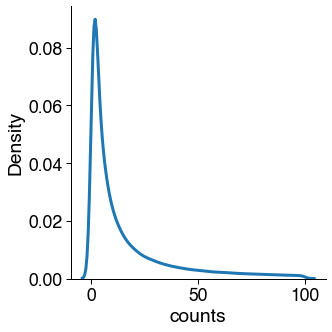

In [209]:
temp = df.loc[(df.counts>0)&(df.counts<100)]
temp['log_counts']=np.log(temp.counts+1)

init_plot_settings(aspect='rectangle')
sns.displot(temp, kind='kde', x='counts', linewidth=3)

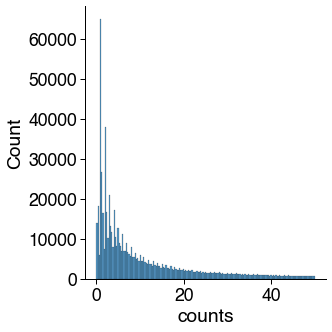

In [210]:
temp = df.loc[(df.counts>0)&(df.counts<50)]
temp['log_counts']=np.log(temp.counts+1)

init_plot_settings(aspect='rectangle')
sns.displot(temp, x='counts')

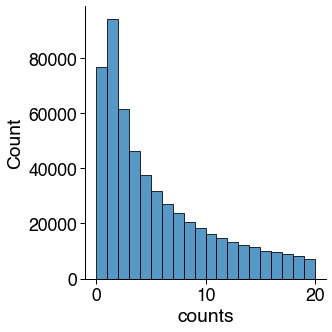

In [211]:
temp = df.loc[(df.counts>0)&(df.counts<20)]
temp['log_counts']=np.log(temp.counts+1)

init_plot_settings(aspect='rectangle')
sns.displot(temp, x='counts', binwidth=1)

## Apply pseudocount

In [212]:
# let's go with 2
pseudocount = 1

df['counts_pseudo'] = df['counts']+pseudocount

## Compute unnormalized entropy

In [224]:
# groupby gene to compute entropy 
# over pi values
e_df = df[['gid',
           'counts_pseudo',
           'g_counts',
           'population']].groupby(['gid',
           'g_counts', 'population']).apply(lambda x: st.entropy(x.counts_pseudo))
e_df = e_df.reset_index().rename({0:'entropy'}, axis=1)

In [225]:
e_df.g_counts.max()

3278119.584713

## Compute normalized entropy

In [227]:
# get number of isoforms expressed per gene overall
n_t_df = df[['gid', 'tid']].groupby('gid').nunique().reset_index().rename({'tid':'n_t'}, axis=1)
e_df = e_df.merge(n_t_df, how='left',
                  on='gid')

In [228]:
# normalize entropy values to max entropy values computed using 
# this stragtegy
# https://mc-stan.org/posterior/reference/entropy.html
e_df['norm_entropy'] = e_df.entropy/np.log(e_df.n_t)

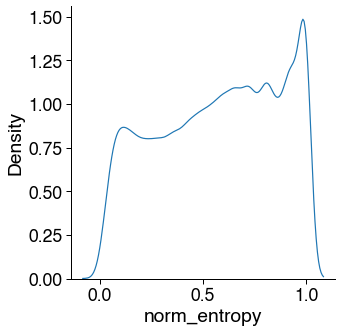

In [229]:
# plot distribution of entropies
sns.displot(e_df, kind='kde', x='norm_entropy')

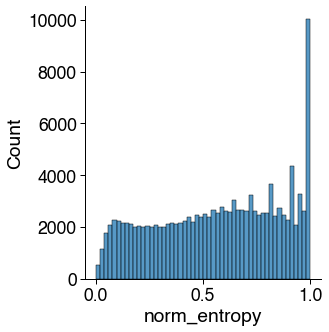

In [217]:
# plot distribution of entropies
sns.displot(e_df, kind='hist', x='norm_entropy')
# peaks are probably at the different theoretical maxes maybe?

## Need to look more into filtering

## First, lets see how gene expression affects entropy distributions

Using the sums of gene counts in each population, because that's how we're now computing entropy

In [301]:
gene_df = df[['gid', 'population', 'g_counts']].drop_duplicates()
print(len(gene_df.index))

195144


In [302]:
drop_cols = [c for c in ['g_counts','log_g_counts', 'decile', 'cut_8', 'cut_10', 'g_counts_x', 'g_counts_y'] if c in e_df.columns]
e_df.drop(drop_cols, axis=1, inplace=True)

In [303]:
len(gene_df)

195144

In [304]:
# log counts + 1
gene_df['log_g_counts'] = np.log(gene_df['g_counts']+1)

# add deciles to each gene / sample combination
_, bin_edges = pd.qcut(gene_df['log_g_counts'],
                       q=10, labels=False,
                       retbins=True,
                       duplicates='drop')

# You can assign deciles using these bin edges if needed
gene_df['decile'] = pd.cut(gene_df['log_g_counts'],
                           bins=bin_edges,
                           labels=False,
                           include_lowest=True)

_, bin_edges_counts = pd.qcut(gene_df['g_counts'],
                       q=10, labels=False,
                       retbins=True,
                       duplicates='drop')

# gene_df['decile'] = pd.qcut(gene_df['log_g_counts'],
#                             q=10, labels=False,
#                             duplicates='drop')

gene_df['cut_8'] = pd.cut(gene_df['log_g_counts'],
                            bins=8)

gene_df['cut_10'] = pd.cut(gene_df['log_g_counts'],
                            bins=10)

<AxesSubplot:xlabel='decile', ylabel='log_g_counts'>

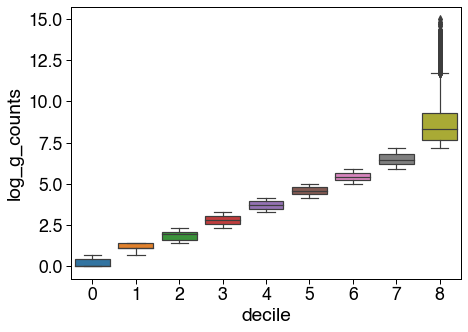

In [305]:
# look at gene counts per decile
sns.boxplot(gene_df, x='decile', y='log_g_counts')

<AxesSubplot:xlabel='cut_8', ylabel='log_g_counts'>

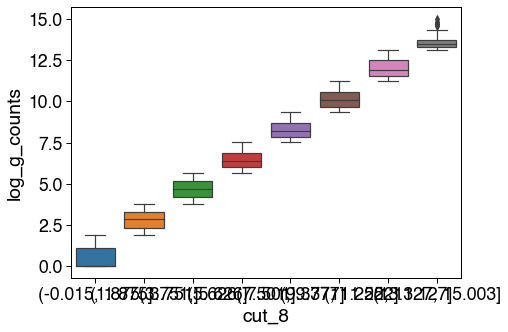

In [306]:
# look at gene counts per decile
sns.boxplot(gene_df, x='cut_8', y='log_g_counts')

In [307]:
e_df = e_df.merge(gene_df, 
                  how='left',
                  on=['population', 'gid'])

<AxesSubplot:xlabel='decile', ylabel='norm_entropy'>

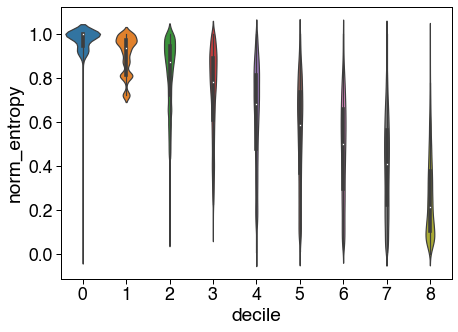

In [308]:
# plot entropy values by different gene expression deciles
# look at gene counts per decile
sns.violinplot(e_df, x='decile', y='norm_entropy')

<AxesSubplot:xlabel='cut_8', ylabel='norm_entropy'>

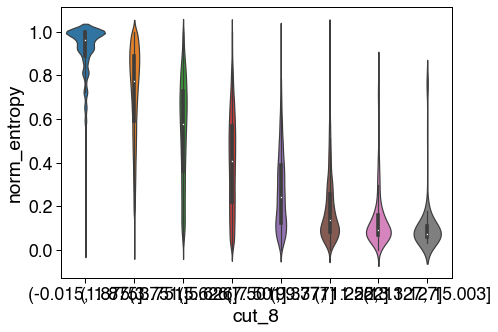

In [309]:
# plot entropy values by different gene expression deciles
# look at gene counts per decile
sns.violinplot(e_df, x='cut_8', y='norm_entropy')

<AxesSubplot:xlabel='cut_10', ylabel='norm_entropy'>

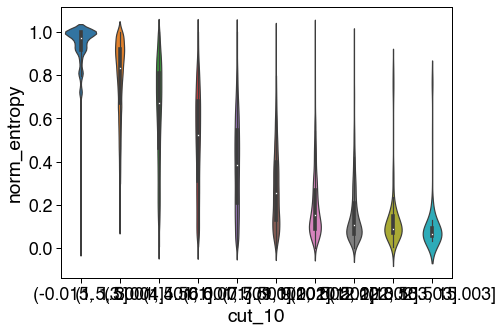

In [312]:
# plot entropy values by different gene expression deciles
# look at gene counts per decile
sns.violinplot(e_df, x='cut_10', y='norm_entropy')

In [313]:
e_df[['norm_entropy', 'decile']].groupby('decile').min()

,norm_entropy
decile,
0,0.002458
1,0.721928
2,0.084839
3,0.119045
4,0.012468
5,0.017630
6,0.026828
7,0.009293
8,0.000957


In [314]:
e_df[['norm_entropy', 'decile']].groupby('decile').max()

,norm_entropy
decile,
0,1.000000
1,1.000000
2,1.000000
3,1.000000
4,1.000000
5,1.000000
6,1.000000
7,1.000000
8,0.999217


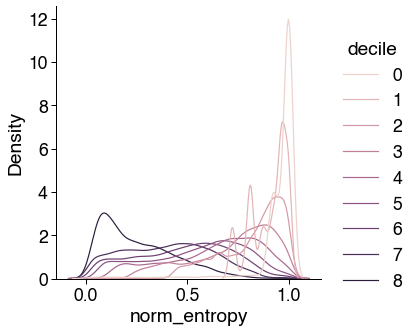

In [315]:
# plot entropy values by different gene expression deciles
# look at gene counts per decile
sns.displot(e_df, hue='decile', x='norm_entropy',
            common_norm=False, kind='kde')

In [316]:
gene_df[['decile', 'gid']].groupby('decile').nunique()

,gid
decile,
0,8816
1,6695
2,6801
3,6310
4,5747
5,5472
6,5010
7,4260
8,3175


In [317]:
gene_df[['cut_8', 'gid']].groupby('cut_8').nunique()

,gid
cut_8,
"(-0.015, 1.875]",10879
"(1.875, 3.751]",9059
"(3.751, 5.626]",8230
"(5.626, 7.501]",5415
"(7.501, 9.377]",2180
"(9.377, 11.252]",684
"(11.252, 13.127]",180
"(13.127, 15.003]",43


In [318]:
gene_df[['cut_10', 'gid']].groupby('cut_10').nunique()

,gid
cut_10,
"(-0.015, 1.5]",10132
"(1.5, 3.001]",8511
"(3.001, 4.501]",7542
"(4.501, 6.001]",6706
"(6.001, 7.501]",4344
"(7.501, 9.002]",2039
"(9.002, 10.502]",822
"(10.502, 12.002]",298
"(12.002, 13.503]",107


In [298]:
bin_edges

array([ 0.        ,  0.69314718,  1.38629436,  2.30258509,  3.25809654,
        4.14313473,  4.99721237,  5.91889366,  7.16858032, 15.00278082])

In [299]:
bin_edges_counts

array([0.00000000e+00, 1.00000000e+00, 3.00000000e+00, 9.00000000e+00,
       2.50000000e+01, 6.20000000e+01, 1.47000014e+02, 3.70999926e+02,
       1.29700055e+03, 3.27811958e+06])

## Testing -- wilcoxon paired tests between each group of samples

In [361]:
len(e_df.index)

195144

In [362]:
# also filter out things with 1 n_t
temp2 = e_df.copy(deep=True)
temp2[['gid','n_t']].groupby('n_t').nunique().rename({'gid':'n_g'}, axis=1).head()
print(len(temp2.index))
temp2 = temp2.loc[temp2.n_t > 1]
print(len(temp2.index))

# filter on gene counts -- let's just filter out
# unexpressed genes first - done below
# min_g_counts = 0
# print(len(temp2))
# temp2 = temp2.loc[temp2.g_counts>min_g_counts]
# print(len(temp2))

195144
130768


[Text(0.5, 1.0, 'Greater')]

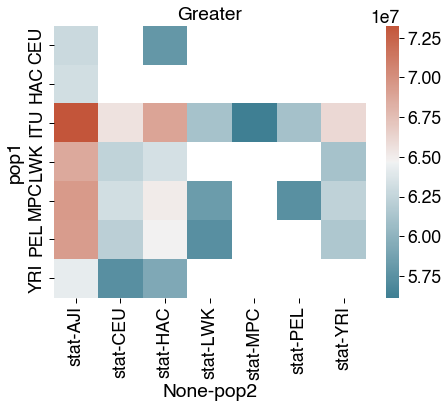

In [377]:
from itertools import combinations, permutations

# List of population elements
pops = temp2.population.unique().tolist()

# Get all unique pairs
# pairs = list(combinations(pops, 2))
pairs = list(permutations(pops, 2))


stats = []
pvals = []
pop1s = []
pop2s = []

# Print each pair
for pair in pairs:
    pop1 = pair[0]
    pop2 = pair[1]
    
    # entropy values
    temp = temp2.loc[temp2.population.isin(pair)]
    temp.population.unique().tolist()

    temp = temp[['gid', 'population',
          'g_counts',
          'norm_entropy']].pivot(index='gid',
                                 columns='population',
                                 values=['g_counts', 'norm_entropy'])
    temp.columns = ['_'.join(col) for col in temp.columns]

    # minimum gene counts / population
    min_g_counts = 0
    g_counts_cols = [c for c in temp.columns if 'g_counts' in c]
    # print(len(temp.index))
    temp = temp.loc[(temp[g_counts_cols]>0).sum(axis=1)==2]
    # temp['temp'] = (temp[g_counts_cols]>0).sum(axis=1)==2
    # print(len(temp.index))    
    
    # get x and y
    x = temp[f'norm_entropy_{pop1}'].tolist()
    y = temp[f'norm_entropy_{pop2}'].tolist()
    
    # x = temp2.loc[temp2.population == pop1, 'norm_entropy'].tolist()
    # y = temp2.loc[temp2.population == pop2, 'norm_entropy'].tolist()

    stat, pval = st.wilcoxon(x, y, alternative='greater')
    stats.append(stat)
    pvals.append(pval)
    pop1s.append(pop1)
    pop2s.append(pop2)
    
result_df = pd.DataFrame()
result_df['pval'] = pvals
result_df['stat'] = stats
result_df['pop1'] = pop1s
result_df['pop2'] = pop2s

# get rid of entries w/ non-sig pvals
result_df = result_df.loc[result_df.pval<=0.05]

pval_df = result_df[['pop1', 'pop2', 'pval']].pivot(index='pop1', columns='pop2')
stat_df = result_df[['pop1', 'pop2', 'stat']].pivot(index='pop1', columns='pop2')

ax = sns.heatmap(stat_df, cmap=sns.diverging_palette(220, 20, as_cmap=True))
ax.set(title='Greater')

[Text(0.5, 1.0, 'Less')]

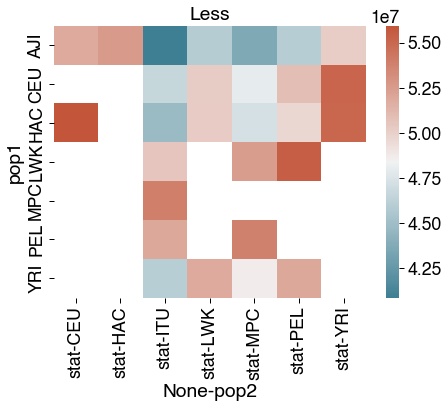

In [378]:
from itertools import combinations, permutations

# List of population elements
pops = temp2.population.unique().tolist()

# Get all unique pairs
# pairs = list(combinations(pops, 2))
pairs = list(permutations(pops, 2))


stats = []
pvals = []
pop1s = []
pop2s = []

# Print each pair
for pair in pairs:
    pop1 = pair[0]
    pop2 = pair[1]
    
    # entropy values
    temp = temp2.loc[temp2.population.isin(pair)]
    temp.population.unique().tolist()

    temp = temp[['gid', 'population',
          'g_counts',
          'norm_entropy']].pivot(index='gid',
                                 columns='population',
                                 values=['g_counts', 'norm_entropy'])
    temp.columns = ['_'.join(col) for col in temp.columns]

    # minimum gene counts / population
    min_g_counts = 0
    g_counts_cols = [c for c in temp.columns if 'g_counts' in c]
    # print(len(temp.index))
    temp = temp.loc[(temp[g_counts_cols]>0).sum(axis=1)==2]
    # temp['temp'] = (temp[g_counts_cols]>0).sum(axis=1)==2
    # print(len(temp.index))    
    
    # get x and y
    x = temp[f'norm_entropy_{pop1}'].tolist()
    y = temp[f'norm_entropy_{pop2}'].tolist()
    
    # x = temp2.loc[temp2.population == pop1, 'norm_entropy'].tolist()
    # y = temp2.loc[temp2.population == pop2, 'norm_entropy'].tolist()

    stat, pval = st.wilcoxon(x, y, alternative='less')
    stats.append(stat)
    pvals.append(pval)
    pop1s.append(pop1)
    pop2s.append(pop2)
    
result_df = pd.DataFrame()
result_df['pval'] = pvals
result_df['stat'] = stats
result_df['pop1'] = pop1s
result_df['pop2'] = pop2s

# get rid of entries w/ non-sig pvals
result_df = result_df.loc[result_df.pval<=0.05]

pval_df = result_df[['pop1', 'pop2', 'pval']].pivot(index='pop1', columns='pop2')
stat_df = result_df[['pop1', 'pop2', 'stat']].pivot(index='pop1', columns='pop2')

ax = sns.heatmap(stat_df, cmap=sns.diverging_palette(220, 20, as_cmap=True))
ax.set(title='Less')

## Try unpaired again

In [383]:
# first add European / non-Eur and African / OOA labels
temp2 = temp2.merge(meta[['population', 'ooa']].drop_duplicates(),
                  how='left',
                  on='population')

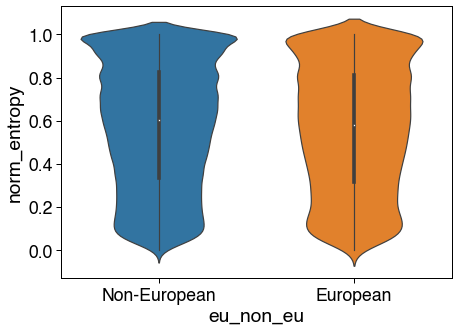

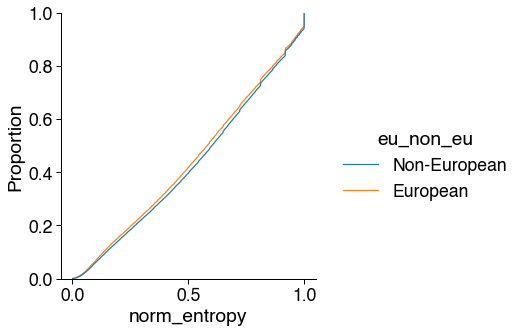

European vs. non-European
Wilcoxon rank-sum test statistic: 7.582064110305257
Wilcoxon rank-sum test pval: 1.7005006746666526e-14


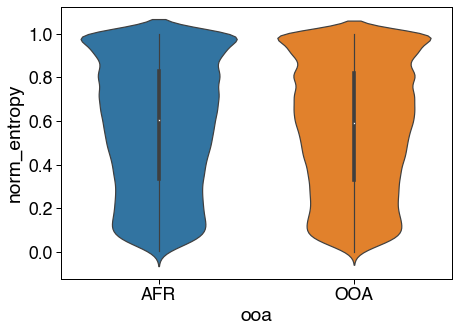

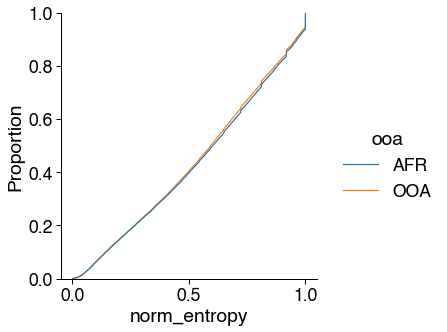

African vs. OOA
Wilcoxon rank-sum test statistic: 4.1699917101269905
Wilcoxon rank-sum test pval: 1.5230535953115118e-05


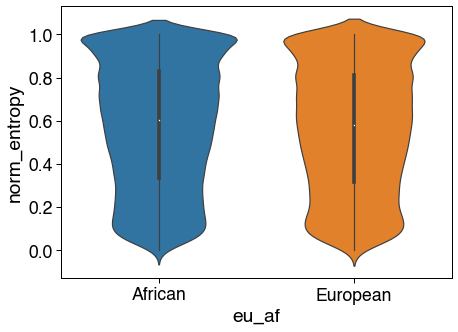

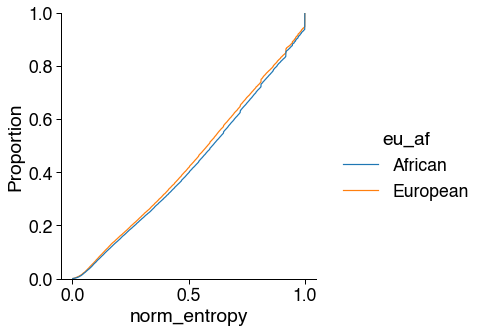

African vs. European
Wilcoxon rank-sum test statistic: 7.140121276909686
Wilcoxon rank-sum test pval: 4.662430475727178e-13


In [384]:
temp2['eu_non_eu'] = 'Non-European'
temp2.loc[temp2['population'].isin(['CEU', 'AJI']), 'eu_non_eu'] = 'European'

# European vs. non-European

sns.violinplot(temp2, x='eu_non_eu', y='norm_entropy')
plt.show()
sns.displot(temp2, hue='eu_non_eu', x='norm_entropy', kind='ecdf')
plt.show()


x = temp2.loc[temp2.eu_non_eu == 'Non-European', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = temp2.loc[temp2.eu_non_eu == 'European', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print('European vs. non-European')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

# African vs. OOA

sns.violinplot(temp2, x='ooa', y='norm_entropy')
plt.show()
sns.displot(temp2, hue='ooa', x='norm_entropy', kind='ecdf')
plt.show()


x = temp2.loc[temp2.ooa == 'AFR', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = temp2.loc[temp2.ooa == 'OOA', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')
print('African vs. OOA')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

# African vs. Eur
temp = temp2.loc[(temp2.ooa=='AFR')|(temp2.eu_non_eu=='European')]
temp['eu_af'] = 'African'
temp.loc[temp.population.isin(['CEU', 'AJI']), 'eu_af'] = 'European'

sns.violinplot(temp, x='eu_af', y='norm_entropy')
plt.show()
sns.displot(temp, hue='eu_af', x='norm_entropy', kind='ecdf')
plt.show()

x = temp.loc[temp.eu_af == 'African', 'norm_entropy'].tolist() # hypothesis is that this is greater
y = temp.loc[temp.eu_af == 'European', 'norm_entropy'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')
print('African vs. European')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

<AxesSubplot:xlabel='None-pop2', ylabel='pop1'>

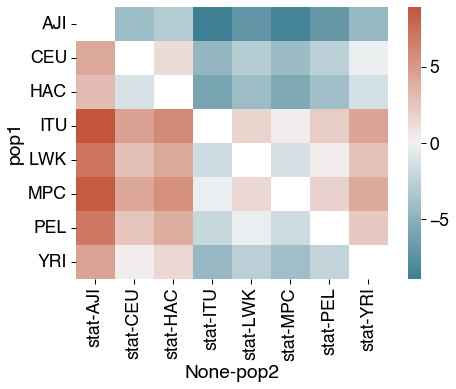

In [386]:
from itertools import combinations, permutations

# List of population elements
pops = temp2.population.unique().tolist()

# Get all unique pairs
# pairs = list(combinations(pops, 2))
pairs = list(permutations(pops, 2))


stats = []
pvals = []
pop1s = []
pop2s = []

# Print each pair
for pair in pairs:
    pop1 = pair[0]
    pop2 = pair[1]
    x = temp2.loc[temp2.population == pop1, 'norm_entropy'].tolist()
    y = temp2.loc[temp2.population == pop2, 'norm_entropy'].tolist()

    stat, pval = st.ranksums(x, y, alternative='two-sided')
    stats.append(stat)
    pvals.append(pval)
    pop1s.append(pop1)
    pop2s.append(pop2)
    
result_df = pd.DataFrame()
result_df['pval'] = pvals
result_df['stat'] = stats
result_df['pop1'] = pop1s
result_df['pop2'] = pop2s

pval_df = result_df[['pop1', 'pop2', 'pval']].pivot(index='pop1', columns='pop2')
stat_df = result_df[['pop1', 'pop2', 'stat']].pivot(index='pop1', columns='pop2')
# hsl(187, 34%, 70%)
sns.heatmap(stat_df, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [387]:
pval_df

pval                                                      \
pop2           AJI       CEU           HAC           ITU           LWK   
pop1                                                                     
AJI            NaN  0.000027  2.629131e-03  4.512197e-19  8.277449e-13   
CEU   2.693325e-05       NaN  2.128242e-01  3.468355e-06  3.625067e-03   
HAC   2.629131e-03  0.212824           NaN  2.663010e-09  2.612806e-05   
ITU   4.512197e-19  0.000003  2.663010e-09           NaN  8.662221e-02   
LWK   8.277449e-13  0.003625  2.612806e-05  8.662221e-02           NaN   
MPC   1.393869e-17  0.000017  2.130045e-08  7.610625e-01  1.604236e-01   
PEL   4.173482e-12  0.008840  8.559957e-05  3.927506e-02  7.340408e-01   
YRI   7.065636e-06  0.792389  1.275953e-01  1.117916e-05  7.788243e-03   

                                            
pop2           MPC           PEL       YRI  
pop1                                        
AJI   1.393869e-17  4.173482e-12  0.000007  
CEU   1.729538e-05  8.840073e-03  0.792389  
HAC   2.130045e-08  8.559957e-05  0.127595  
ITU   7.610625e-01  3.927506e-02  0.000011  
LWK   1.604236e-01  7.340408e-01  0.007788  
MPC            NaN  8.009700e-02  0.000052  
PEL   8.009700e-02           NaN  0.018180  
YRI   5.157097e-05  1.817977e-02       NaN

In [344]:


# # gene exp filter
# min_g_counts = 0
# print(len(temp.index))
# temp = temp.loc[temp.g_counts > 0]
# print(len(temp.index))


32692
31081


In [359]:
# # entropy values
# temp = temp2.loc[temp2.population.isin(pair)]
# temp.population.unique().tolist()

# temp = temp[['gid', 'population',
#       'g_counts',
#       'norm_entropy']].pivot(index='gid',
#                              columns='population',
#                              values=['g_counts', 'norm_entropy'])
# temp.columns = ['_'.join(col) for col in temp.columns]

# # minimum gene counts / population
# min_g_counts = 0
# g_counts_cols = [c for c in temp.columns if 'g_counts' in c]
# print(len(temp.index))
# temp = temp.loc[(temp[g_counts_cols]>0).sum(axis=1)==2]
# # temp['temp'] = (temp[g_counts_cols]>0).sum(axis=1)==2
# print(len(temp.index))

# # entropy cols


16346
15091


In [357]:
temp.loc[temp.g_counts_MPC==0].head()

,g_counts_MPC,g_counts_PEL,norm_entropy_MPC,norm_entropy_PEL,temp
gid,,,,,
ENSG00000005421.9,0.0,0.000000,1.0,1.000000,False
ENSG00000007264.15,0.0,2.000000,1.0,0.811278,False
ENSG00000007372.25,0.0,4.013780,1.0,0.917530,False
ENSG00000038427.16,0.0,1.999999,1.0,0.979167,False
ENSG00000049247.14_ENSG00000302605.1,0.0,0.000000,1.0,0.545506,False


In [348]:
temp.loc[temp.g_counts_MPC==0]

,g_counts_MPC,g_counts_PEL,norm_entropy_MPC,norm_entropy_PEL
gid,,,,
ENSG00000005421.9,0.0,0.000000,1.000000,1.000000
ENSG00000007264.15,0.0,2.000000,1.000000,0.811278
ENSG00000007372.25,0.0,4.013780,1.000000,0.917530
ENSG00000038427.16,0.0,1.999999,1.000000,0.979167
ENSG00000049247.14_ENSG00000302605.1,0.0,0.000000,1.000000,0.545506
...,...,...,...,...
ENSG00000310537.1_ENSG00000276840.1,0.0,0.000000,0.962271,0.921492
novelGene_ENSG00000124225.16_AS,0.0,19.000000,1.000000,0.591673
novelGene_ENSG00000243063.1_AS,0.0,25.488286,1.000000,0.950777
